In [18]:
import json
from pathlib import Path
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.models.classification_rnn import ClassificationRNN

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else "cpu"

best_params = {'hidden_size': 128,
 'num_layers': 1,
 'dropout': 0.1,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'batch_size': 256,
 'epochs': 20,
 'grad_clip': 1.0}


In [19]:
# point to your best_params file
#json_path = Path("checkpoints/classifier") / \
#            "best_params_20251202_183956.json"  # adjust name if needed

#with open(json_path, "r") as f:
#    best_params = json.load(f)

# 4. Classifying Behaviours

After clustering the trajectories, we train a classifier to assign new trajectory segments to their most likely behaviour cluster. The classifier takes a past 30-minute window as input—created by sliding a fixed-length window across each trajectory—and predicts the corresponding cluster label learned during the unsupervised clustering stage. In this notebook, we load the trained model and show its performance and predictions; the full training procedure is available in `models/train_classifier.ipynb`.

HDBSCAN identified **10 behaviour clusters** in the latent space. After tuning the hyperparameters (`hidden size`, `number of layers`, `dropout`, `learning rate`, and `weight decay`), the best-performing classifier used the following settings:

In [20]:
best_params

{'hidden_size': 128,
 'num_layers': 1,
 'dropout': 0.1,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'batch_size': 256,
 'epochs': 20,
 'grad_clip': 1.0}

In [ ]:
# Start with loading the data
def make_loaders(batch_size):
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

train_traj = np.load(os.path.join("data/aisdk/processed/windows/train_trajectories.npz"))
val_traj = np.load(os.path.join("data/aisdk/processed/windows/val_trajectories.npz"))
test_traj = np.load(os.path.join("data/aisdk/processed/windows/test_trajectories.npz"))

X_train, X_val, X_test = train_traj["past"], val_traj["past"], test_traj["past"]
y_train, y_val, y_test = train_traj["cluster"], val_traj["cluster"], test_traj["cluster"]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

train_loader, val_loader = make_loaders(256)


print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique clusters:", np.unique(y_test))

X_test shape: (1702, 30, 5)
y_test shape: (1702, 30, 5)
Unique clusters: [-1.3003587  -1.29931016 -1.29822383 ...  1.47653615  1.47654176
  1.47739012]


The validation loss and accuracy 

In [37]:
# Identify majority class in train and val
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_majority_cls = int(train_classes[np.argmax(train_counts)])

val_classes, val_counts = np.unique(y_val, return_counts=True)
val_majority_cls = int(val_classes[np.argmax(val_counts)])

print(f"Train majority class: {train_majority_cls} ({train_counts.max()} samples)")
print(f"Val majority class:   {val_majority_cls} ({val_counts.max()} samples)")

# Build constant logits that always predict the majority class
# We set a large positive logit for the majority class, zeros elsewhere
crit = nn.CrossEntropyLoss()

def constant_majority_loss_and_acc(X_t, y_t, majority_cls, num_classes):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    X_t = X_t.to(device)
    y_t = y_t.to(device)

    N = X_t.shape[0]
    # Create logits: shape (N, num_classes)
    logits = torch.zeros((N, num_classes), dtype=torch.float32, device=device)
    logits[:, majority_cls] = 10.0  # strong preference for the majority class

    # Loss
    loss = crit(logits, y_t).item()

    # Accuracy
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
    return loss, acc

num_classes = int(y_train.max() + 1)

train_loss_baseline, train_acc_baseline = constant_majority_loss_and_acc(
    X_train_t, y_train_t, train_majority_cls, num_classes
)
val_loss_baseline, val_acc_baseline = constant_majority_loss_and_acc(
    X_val_t, y_val_t, val_majority_cls, num_classes
)

print("\nMajority-class baseline:")
print(f"  Train -> Loss: {train_loss_baseline:.4f}, Acc: {train_acc_baseline:.4f}")
print(f"  Val   -> Loss: {val_loss_baseline:.4f}, Acc: {val_acc_baseline:.4f}")

Train majority class: 3 (1557 samples)
Val majority class:   3 (1557 samples)

Majority-class baseline:
  Train -> Loss: 0.0001, Acc: 0.9148
  Val   -> Loss: 0.0001, Acc: 0.9148


In [38]:
# Check how many points are in each cluster for train and val sets
unique, counts = np.unique(y_train, return_counts=True)
train_cluster_counts = dict(zip(unique, counts))
print("\nTraining set cluster distribution:")
for cluster, count in train_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")  

unique, counts = np.unique(y_val, return_counts=True)
val_cluster_counts = dict(zip(unique, counts))
print("\nValidation set cluster distribution:") 
for cluster, count in val_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")


Training set cluster distribution:
  Cluster -1: 145 samples
  Cluster 3: 1557 samples

Validation set cluster distribution:
  Cluster -1: 145 samples
  Cluster 3: 1557 samples


In [39]:
checkpoint = torch.load('checkpoints/classifier/classification_rnn_model.pt')
print(checkpoint.keys())


odict_keys(['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0', 'gru.weight_ih_l0_reverse', 'gru.weight_hh_l0_reverse', 'gru.bias_ih_l0_reverse', 'gru.bias_hh_l0_reverse', 'gru.weight_ih_l1', 'gru.weight_hh_l1', 'gru.bias_ih_l1', 'gru.bias_hh_l1', 'gru.weight_ih_l1_reverse', 'gru.weight_hh_l1_reverse', 'gru.bias_ih_l1_reverse', 'gru.bias_hh_l1_reverse', 'gru.weight_ih_l2', 'gru.weight_hh_l2', 'gru.bias_ih_l2', 'gru.bias_hh_l2', 'gru.weight_ih_l2_reverse', 'gru.weight_hh_l2_reverse', 'gru.bias_ih_l2_reverse', 'gru.bias_hh_l2_reverse', 'gru.weight_ih_l3', 'gru.weight_hh_l3', 'gru.bias_ih_l3', 'gru.bias_hh_l3', 'gru.weight_ih_l3_reverse', 'gru.weight_hh_l3_reverse', 'gru.bias_ih_l3_reverse', 'gru.bias_hh_l3_reverse', 'gru.weight_ih_l4', 'gru.weight_hh_l4', 'gru.bias_ih_l4', 'gru.bias_hh_l4', 'gru.weight_ih_l4_reverse', 'gru.weight_hh_l4_reverse', 'gru.bias_ih_l4_reverse', 'gru.bias_hh_l4_reverse', 'classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', '

In [40]:
# Load the model
checkpoint = torch.load('checkpoints/classifier/classification_rnn_model.pt')
state_dict = torch.load('checkpoints/classifier/classification_rnn_model.pt', map_location=device)

model = ClassificationRNN(
        input_size=5,
        hidden_size=best_params["hidden_size"],
        num_classes=10, 
).to(device)

model.load_state_dict(state_dict)


<All keys matched successfully>

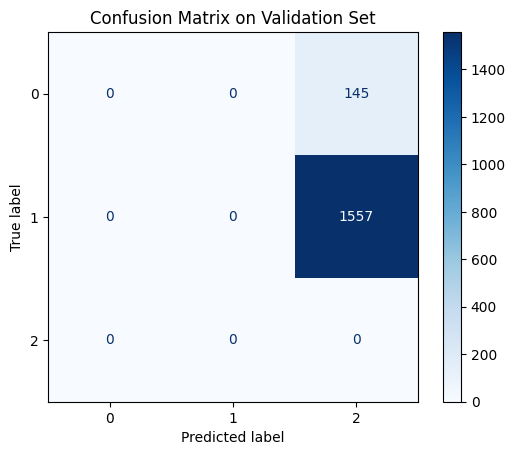

In [41]:
# Make confusion matrix on validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())   
cm = confusion_matrix(y_val, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()

# 5. Trajectory Prediction